## Imports and Data load

In [260]:
%pip install sweetviz
%pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [261]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [262]:
train_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/train.csv')
test_features = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/test.csv')

test_target = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/gender_submission.csv')

In [263]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [264]:
test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

Let's write a simple function to quickly review data

In [265]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);
    print('------------------------------')
    print('|    Dataset information.    |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('|        First 10 rows.      |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('|        Last 10 rows.          |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Descriptive statistics. |')
    print('---------------------------')
    print(df.describe())
    print('----------------------')
    print('| Sum of duplicates. |')
    print('----------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('|    Covariance matrix.  |')
    print('--------------------------')
    plt.show()

------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Survived  Pclass  \
0            1        

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/924560989.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);


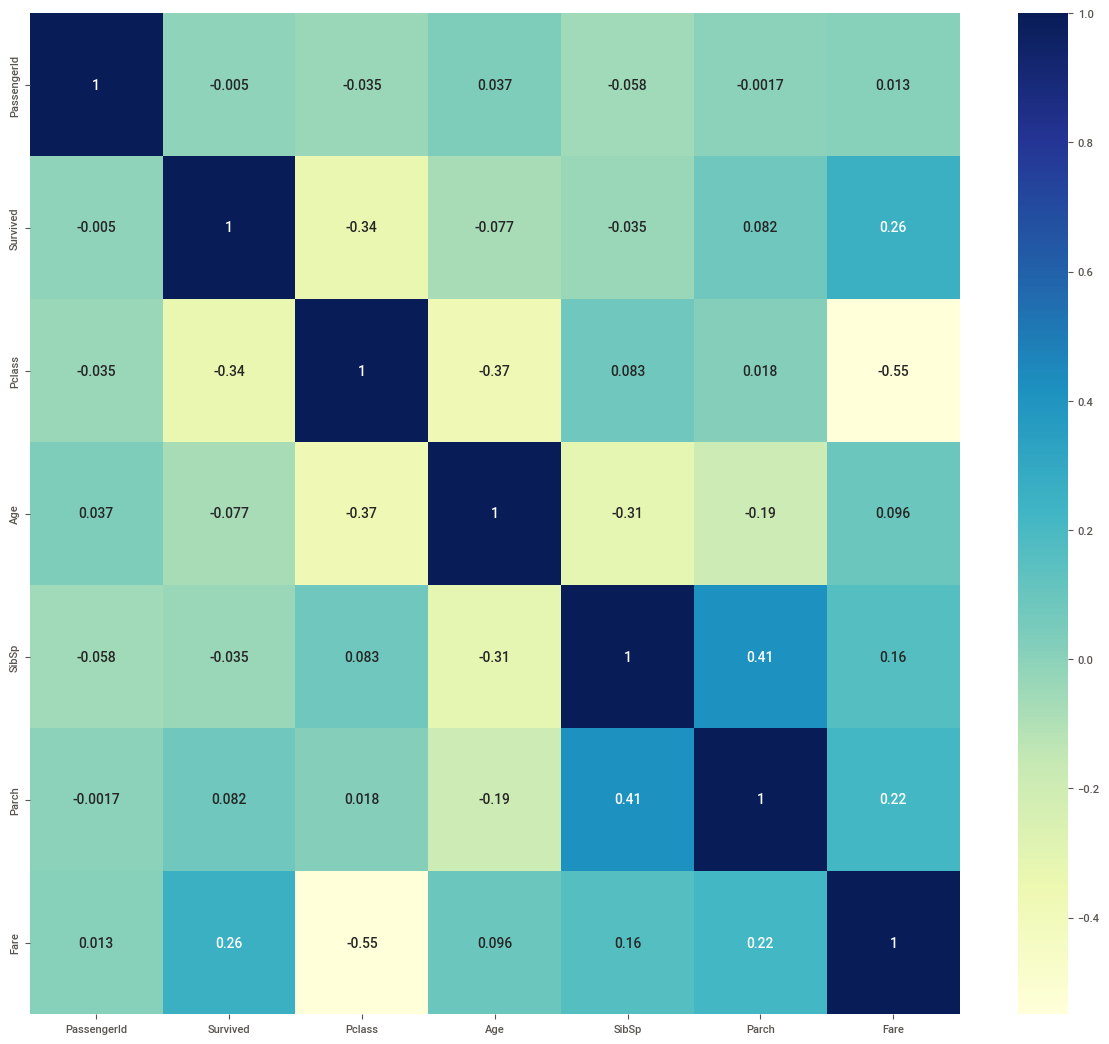

In [266]:
info_df(train_data)

In [267]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.900000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Pclass                                          Name     Sex  \
0          892      

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/924560989.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);


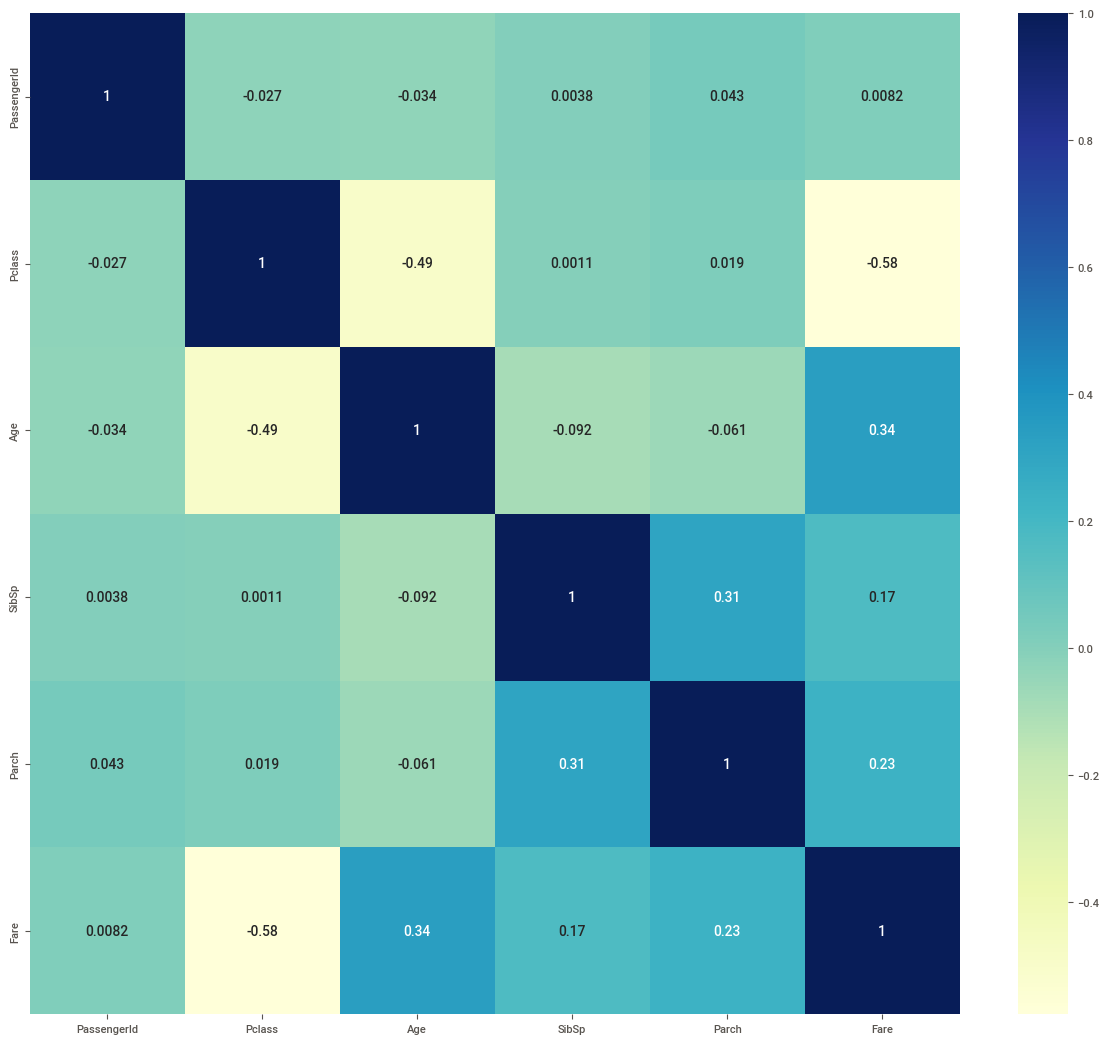

In [268]:
info_df(test_features)

In [269]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_features.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.600000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.200000
Cabin,78.200000


We can see that in columns `Age`, `Cabin` and `Embarked` has a gaps in data. And also `Age` has a different data type (Float64). Let's make change to these mistakes!

**Rename titels**

In [270]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [271]:
columns = {}
for i in train_data.columns:
    columns[i] = i.lower()
train_data = train_data.rename(columns=columns)
test_features = test_features.rename(columns=columns)

**Duplicates**

In [272]:
train_data = train_data.drop('passengerid', axis = 1)
train_data.duplicated().sum()

0

In [273]:
test_features = test_features.drop('passengerid', axis = 1)
test_features.duplicated().sum()

0

**Implicit Duplicates**

Consider possible implicit duplicates

In [274]:
for i in ['sex', 'sibsp','ticket', 'cabin','embarked']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

sex
------------------------------------------------------------
['male' 'female']
------------------------------------------------------------
sibsp
------------------------------------------------------------
[1 0 3 4 2 5 8]
------------------------------------------------------------
ticket
------------------------------------------------------------
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29

As you can see, tickets, cabin and embarker has a mistakes and ambiguity.

**Tickets**

First of all, let's have look on the tickets. We can replace code name and number of the tickets  and leave only number, because code name does not provide useful information. Also we can drop it, and... just do it, because, in my opinion, it is not useful information for our models, like a name.

P.S. In fact, there is useful information, but is this case i suggest relyimg on the type of cabin 

In [275]:
train_data = train_data.drop(['ticket','name'], axis = 1)
test_features = test_features.drop(['ticket','name'], axis = 1)

**Fill in the blanks**

I think its not a big deal and we can fill blanks the median value.

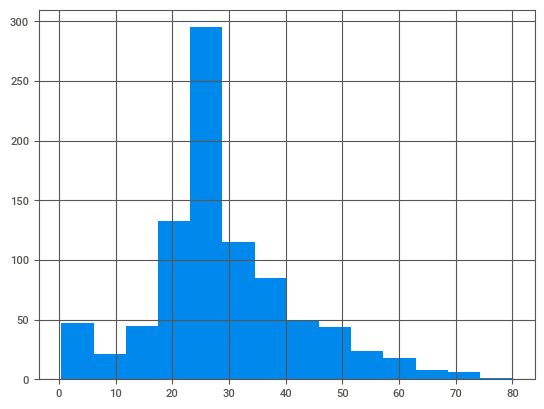

In [276]:
train_data['age'] = train_data['age'].fillna(train_data['age'].median())
train_data['age'].hist(bins=14);

**Cabin**

This point is ambiguous. Because the type of room really could affect survival. But we have a lot of gaps in this column. 

I suggest make a pivot table or just a look on dependency of data between type of room and passenger fare

But before that let's make a replace inplicit duplicates.

In [277]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

In [278]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B51 B53 B55', 'B52 B54 B56',
       'B57 B59 B63 B66', 'B58 B60', 'B61', 'B69', 'B71', 'B78', 'C101',
       'C105', 'C106', 'C116', 'C130', 'C132', 'C22 C26', 'C23 C25 C27',
       'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53', 'C54', 'C55 C57',
       'C6', 'C62 C64', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89', 'C97',
       'D', 'D10 D12', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D34',
       'D37', 'D38', 'D40', 'D43', 'E31', 'E34', 'E39 E41', 'E45', 'E46',
       'E50', 'E52', 'E60', 'F', 'F E46', 'F E57', 'F G63', 'F2', 'F33',
       'F4', 'G6', nan], dtype=object)

Right now we have a 3 ways.
- The first way, we can replace stuck together cabins on single type like B57 B59 etc. to B (median number).
- The second way, we can split this cabins, and attempt recover based on tickets.
- The thierd way, we can drop it. 

In your case choose you way. But i am choose the first.

In [279]:
train_data = train_data.apply(lambda x: x.replace({'C2 C2 C2':'C2', 'F G73': 'G73', 'F E69': 'E69',
                                                     'C2 C2':'C2', 'F G63': 'G63','B51 B53 B55': 'B53', 
                                                     'B57 B59 B63 B66': 'B61', 'B58 B60': 'B59', 'B82B84': 'B81', 
                                                     'B96 B98': 'B97', 'C62C64': 'C63', 'D10 D12': 'D11'}, regex=True))

In [280]:
test_features = test_features.apply(lambda x: x.replace({'B51 B53 B55': 'B53', 'B52 B54 B56': 'B54', 
                                                         'B57 B59 B63 B66': 'B61','B58 B60': 'B59', 'C22 C26': 'C24',
                                                         'C23 C25 C27': 'C25','C55 C57':'C56','C62 C64': 'C63', 
                                                         'D10 D12': 'D11', 'E39 E41': 'E40', 'F E46': 'E46', 'F E57': 'E57',
                                                         'F G63': 'G63'}, regex=True))

In [281]:
train_data = train_data.dropna()
test_features = test_features.dropna()

In [282]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B3', 'B30', 'B35', 'B37', 'B38', 'B39', 'B4',
       'B41', 'B42', 'B49', 'B5', 'B50', 'B53', 'B59', 'B61', 'B69',
       'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86', 'B94',
       'B97', 'C101', 'C103', 'C104', 'C106', 'C110', 'C111', 'C118',
       'C123', 'C124', 'C125', 'C126', 'C128', 'C148', 'C2', 'C22 C26',
       'C23 C25 C27', 'C30', 'C32', 'C45', 'C46', 'C47', 'C49', 'C50',
       'C52', 'C54', 'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78', 'C82',
       'C83', 'C85', 'C86', 'C87', 'C90', 'C91', 'C92', 'C93', 'C95',
       'C99', 'D', 'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28',
       'D30', 'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48',
       'D49', 'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12',
       'E121', 'E17', 'E24', 'E25', 'E31', 'E33', 'E34', 'E36', 'E38',
   

In [283]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B53', 'B54', 'B59', 'B61', 'B69',
       'B71', 'B78', 'C101', 'C105', 'C106', 'C116', 'C130', 'C132',
       'C24', 'C25', 'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53',
       'C54', 'C56', 'C6', 'C63', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89',
       'C97', 'D11', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D37',
       'D38', 'D40', 'D43', 'E31', 'E34', 'E40', 'E45', 'E50', 'E52',
       'E57', 'E60', 'F', 'F2', 'F33', 'F4', 'G6', 'G63'], dtype=object)

Let's separate the cabin type and cabin number and create two new  features.

In [292]:
train_data['type_cabin'] = train_data['cabin'].apply(lambda str: re.findall(r'[a-zA-Z]+',str)[0])
train_data['number_cabin'] = train_data['cabin'].apply(lambda str: int(*(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",str))))

test_features['type_cabin'] = test_features['cabin'].apply(lambda str: re.findall(r'[a-zA-Z]+',str)[0])
test_features['number_cabin'] = test_features['cabin'].apply(lambda str: int(*(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",str))))

TypeError: int() takes at most 2 arguments (3 given)

In [289]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 1 to 889
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      202 non-null    int64  
 1   pclass        202 non-null    int64  
 2   sex           202 non-null    object 
 3   age           202 non-null    float64
 4   sibsp         202 non-null    int64  
 5   parch         202 non-null    int64  
 6   fare          202 non-null    float64
 7   cabin         202 non-null    object 
 8   embarked      202 non-null    object 
 9   type_cabin    202 non-null    object 
 10  number_cabin  202 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 18.9+ KB


In [290]:
train_data['type_cabin']

1      C
3      C
6      E
10     G
11     C
      ..
871    D
872    B
879    C
887    B
889    C
Name: type_cabin, Length: 202, dtype: object

In [291]:
train_data['number_cabin']

1       [85]
3      [123]
6       [46]
10       [6]
11     [103]
       ...  
871     [35]
872     [53]
879     [50]
887     [42]
889    [148]
Name: number_cabin, Length: 202, dtype: object

In [231]:
train_data = train_data.drop(['ticket','name','cabin'], axis = 1)
train_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
1,1,1,female,38.0,1,0,71.2833,C,C,85
3,1,1,female,35.0,1,0,53.1000,S,C,12
6,0,1,male,54.0,0,0,51.8625,S,E,46
10,1,3,female,4.0,1,1,16.7000,S,G,6
11,1,1,female,58.0,0,0,26.5500,S,C,103
...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47.0,1,1,52.5542,S,D,35
872,0,1,male,33.0,0,0,5.0000,S,B,53
879,1,1,female,56.0,0,1,83.1583,C,C,50
887,1,1,female,19.0,0,0,30.0000,S,B,42


**Convert Float to Int**

In [232]:
train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']] = train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']].astype('int16')

In [233]:
train_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
1,1,1,female,38,1,0,71.2833,C,C,85
3,1,1,female,35,1,0,53.1000,S,C,12
6,0,1,male,54,0,0,51.8625,S,E,46
10,1,3,female,4,1,1,16.7000,S,G,6
11,1,1,female,58,0,0,26.5500,S,C,103
...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47,1,1,52.5542,S,D,35
872,0,1,male,33,0,0,5.0000,S,B,53
879,1,1,female,56,0,1,83.1583,C,C,50
887,1,1,female,19,0,0,30.0000,S,B,42


In [237]:
test_features

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [234]:
train_report = sv.analyze(train_data)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same 

In [235]:
train_report.show_html('Train_report.html')

Report Train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
